## Домашняя работа №2

In [240]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as sklearn_LR
from sklearn.model_selection import train_test_split
%matplotlib inline

In [221]:
class linear_regression:
    def __init__(self, eta = 0.9, max_iter = 1e4, min_weight_dist = 1e-8):
        self._eta = eta
        self.max_iter = max_iter
        self.min_weight_dist = min_weight_dist
    
    def _calculate_eta(self, X, Y):
        gr_w, gr_c=self.mserror_grad(X, np.zeros((1, X.shape[1])), 0, Y)
        return self._eta/np.sqrt(np.linalg.norm(gr_w)**2+(gr_c)**2)
    
    def fit(self, X, Y):
        iter_num = 0
        weight_dist = np.inf
        w = np.zeros((1, X.shape[1]))
        c=0
        eta=self._calculate_eta(X, Y)
        while weight_dist > self.min_weight_dist and iter_num < self.max_iter:
            gr_w, gr_c=self.mserror_grad(X, w, c, Y)
            new_w = w - 2 * eta * gr_w
            new_c = c - 2 * eta * gr_c
            weight_dist = np.sqrt(np.linalg.norm(new_w - w)**2+(new_c - c)**2)
            iter_num += 1
            w = new_w
            c = new_c
        self.w=w
        self.c=c
        
    def predict(self, X):
        return X.dot(self.w.T)+self.c
    
    def test(self, X, Y):
        return self.mserror(X, self.w, self.c, Y)
    
    @staticmethod
    def mserror(X, w, c0, y_real):
        y = X.dot(w.T)+c0
        return (np.sum((y - y_real)**2) / y_real.shape[0]) + 0.5 * np.sum(w**2)
    
    @staticmethod
    def mserror_grad(X, w, c0, y_real):
        delta=(X.dot(w.T)+c0-y_real)
        return (2*delta.T.dot(X)/y_real.shape[0]) + 1 * w, (np.sum(2*delta)/y_real.shape[0])

In [222]:
class polynomial_regression(linear_regression):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
        
    @staticmethod
    def generate_features(x, max_power):
        x=x[:, np.newaxis]
        return np.concatenate([x**i for i in range(1, max_power+1)], axis=1)
    
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y[:, np.newaxis])
        
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power)).flatten()
    
    def test(self, x, y):
        return super().test(self.generate_features(x, self.max_power), y[:, np.newaxis])
    
    @staticmethod
    def mserror(X, w, c0, y_real):
        y = X.dot(w.T)+c0
        return (np.sum((y - y_real)**2) / y_real.shape[0]) + 0.5 * np.sum(w**2)
    
    @staticmethod
    def mserror_grad(X, w, c0, y_real):
        delta=(X.dot(w.T)+c0-y_real)
        return (2*delta.T.dot(X)/y_real.shape[0]) + 1 * w, (np.sum(2*delta)/y_real.shape[0])
    
class polynomial_regression_sklearn(sklearn_LR):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
    generate_features=staticmethod(polynomial_regression.generate_features)
    
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y)
        
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power))

In [223]:
our_mod=polynomial_regression(2)
our_mod.fit(x_data, f_data)
sk_mod=polynomial_regression_sklearn(2)
sk_mod.fit(x_data, f_data)
print(our_mod.w)
print(sk_mod.coef_)
print(our_mod.c, sk_mod.intercept_)

[[-240.42847287   -7.60087465]]
[-245.99569456   -5.82400107]
-89.67756117894679 -219.69194405215603


In [224]:
def f(x):
    return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3
np.random.seed(16)
x_data = np.random.uniform(-10, 10, 10)
f_data = [f(i) for i in x_data] + np.random.uniform(-1000, 1000, 10)

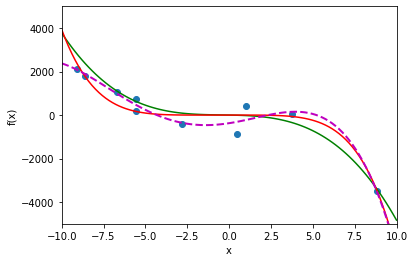

In [277]:
#Актуальные данные
dots = np.linspace(-10, 10, 100)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
model1 = polynomial_regression(5, 0.01)
model1.fit(x_data, f_data)
plt.plot(dots, model1.predict(dots), color='r')

#Sklearn
model2 = polynomial_regression_sklearn(4)
model2.fit(x_data, f_data)
plt.plot(dots, model2.predict(dots), 'm--', linewidth=2)

In [215]:
our_mod.predict(x_data)

array([ 1008.10352262,  -202.69136765,  -341.29467471,  1467.56291837,
         521.04549126,  1008.76027505, -1105.47027487,  1183.50095152,
        1415.13358078, -2801.62831804])

In [216]:
sk_mod.predict(x_data)

array([  963.31967725,  -334.90351389,  -475.12730327,  1534.8970571 ,
         420.32419835,   964.08251447, -1231.1831019 ,  1171.29729954,
        1464.18020411, -2842.51273709])

После применения l2 регуляризации видно, что предсказания изменились.

In [217]:
def r_square(y, y_real):
    ss_total=np.sum((y_real-np.mean(y_real))**2)
    ss_res=np.sum((y_real-y)**2)
    return 1-ss_res/ss_total
print(r_square(model2.predict(x_data), f_data))

0.9607644096888515


In [231]:
indexes=np.arange(len(f_data))%5
y_actual=[]
y_predicted=[]

for i in range(5):
    y_actual.append(f_data[indexes==i])
    mod=polynomial_regression_sklearn(6)
    mod.fit(x_data[indexes!=i], f_data[indexes!=i])
    y_predicted.append(mod.predict(x_data[indexes==i]))
    
y_actual=np.concatenate(y_actual)
y_predicted=np.concatenate(y_predicted)
print(r_square(y_predicted, y_actual))

-7794.627883580687


In [219]:
np.sum((y_actual-np.mean(y_actual))**2)/len(y_actual)

2249573.810796306

In [266]:
X_train, X_test, y_train, y_test = train_test_split(x_data, f_data, test_size=0.33, random_state=42)

In [267]:
mod=polynomial_regression_sklearn(6)
mod.fit(X_train, y_train)
print(r_square(mod.predict(X_test), y_test))

0.02371611999682499


Определенно, кросс валидация лучше, чем просто обучать на части от датасета. R square стал лучше, но это не так явно выражено почему-то.

In [271]:
y_test

array([1799.10906399, -851.08250932,  206.52054624,  745.4884675 ])

In [270]:
mod.predict(X_test)

array([2629.60090629,  482.3645782 , -213.55373556, -216.80808708])

In [233]:
y_predicted

array([ 8.70967833e+02,  8.72533799e+02,  4.15762579e+02, -3.02967752e+03,
       -7.94091698e+02,  9.08462214e+02,  6.58242889e+04,  3.74014108e+04,
       -2.14694296e+03, -4.15840205e+05])

In [237]:
f_data

array([  745.4884675 ,  -851.08250932,   422.69810766,  2129.66866668,
        -413.07267878,   206.52054624,    44.24369404,  1046.66448866,
        1799.10906399, -3495.863552  ])

In [245]:
x_data

array([-5.53417842,  0.46326683,  1.01402913, -9.087961  , -2.78542329,
       -5.53838117,  3.77452324, -6.7253715 , -8.59350266,  8.8202172 ])